# Analysing Calgary Campinas Dataset

In [1]:
import seaborn_image as isns
from uda.calgary_campinas_dataset import CalgaryCampinasDataset

data_dir = "/home/iailab36/iser/uda-data"

In [2]:
train_dataset = CalgaryCampinasDataset(data_dir, site=2, fold=1, train=True)
test_dataset = CalgaryCampinasDataset(data_dir, site=2, fold=1, train=False)

print("# train examples:", len(train_dataset))
print("# train examples:", len(test_dataset))

0 CC0320_ge_3_57_F.nii.gz (200, 256, 256)
1 CC0321_ge_3_51_F.nii.gz (200, 256, 256)
2 CC0322_ge_3_59_M.nii.gz (196, 256, 256)
3 CC0323_ge_3_56_M.nii.gz (200, 256, 256)
4 CC0324_ge_3_56_M.nii.gz (200, 256, 256)
5 CC0325_ge_3_55_F.nii.gz (200, 256, 256)
6 CC0326_ge_3_55_M.nii.gz (200, 256, 256)
7 CC0327_ge_3_50_M.nii.gz (200, 256, 256)
8 CC0328_ge_3_56_F.nii.gz (176, 256, 256)
9 CC0329_ge_3_58_F.nii.gz (200, 256, 256)
10 CC0330_ge_3_57_F.nii.gz (200, 256, 256)
11 CC0331_ge_3_61_F.nii.gz (200, 256, 256)
12 CC0332_ge_3_53_F.nii.gz (164, 256, 256)
13 CC0333_ge_3_41_M.nii.gz (200, 256, 256)
14 CC0334_ge_3_45_M.nii.gz (200, 256, 256)
15 CC0335_ge_3_54_F.nii.gz (200, 256, 256)
16 CC0336_ge_3_53_F.nii.gz (200, 256, 256)
17 CC0337_ge_3_59_F.nii.gz (200, 256, 256)
18 CC0338_ge_3_51_M.nii.gz (184, 256, 256)
19 CC0339_ge_3_59_F.nii.gz (200, 256, 256)
20 CC0340_ge_3_49_M.nii.gz (200, 256, 256)
21 CC0341_ge_3_60_M.nii.gz (200, 256, 256)
22 CC0342_ge_3_50_M.nii.gz (212, 256, 256)
23 CC0343_ge_3_54_F.n

In [3]:
print(train_dataset.data.shape)
print(train_dataset.label.shape)
print(train_dataset.voxel_dim.shape)

torch.Size([7832, 1, 256, 256])
torch.Size([7832, 1, 256, 256])
torch.Size([7832, 3])


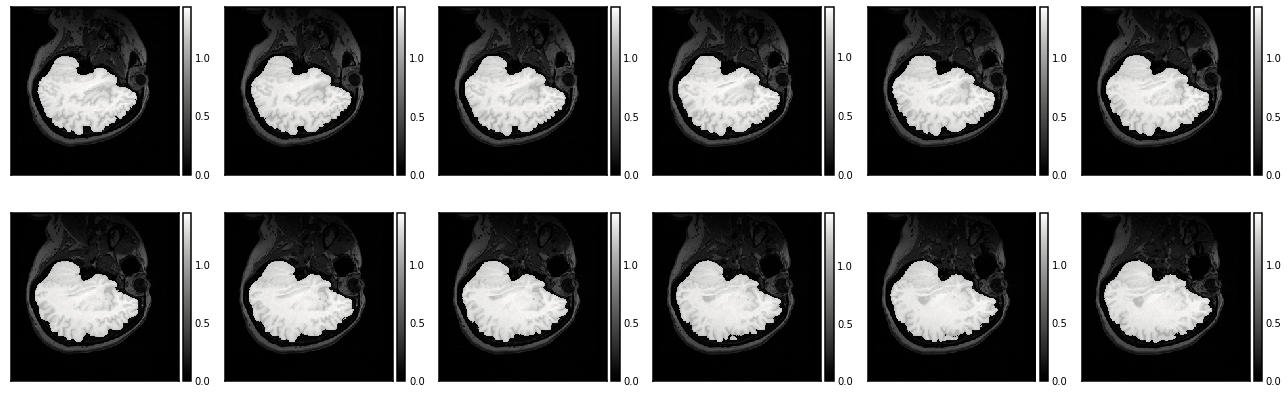

In [4]:
COLS = 6
N = 64
M = N + COLS*2

g = isns.ImageGrid(list((train_dataset.data + train_dataset.label)[N:M].squeeze()), col_wrap=COLS, cmap='gray')

## Training U-Net model

In [ ]:
import torch
import torch.nn.functional as F
from uda import UNetConfig, UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# We use one encoder block less than the original U-Net, since our input is of shape (256, 256)
config = UNetConfig(
    n_classes=1,
    encoder_blocks=(
        (1, 64, 64),
        (64, 128, 128),
        (128, 256, 256),
        (256, 512, 512),
    ),
    decoder_blocks=(
        (512, 256, 256),
        (256, 128, 128),
        (128, 64, 64),
    ),
)

model = UNet(config)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# from torchsummaryX import summary
# summary(model, x=torch.randn(1, 1, 512, 512))

In [ ]:
model.to(device)

for epoch in range(2):
    for i, (data, label, _) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)

        optim.zero_grad()
        output = model(data).sigmoid()
        loss = F.binary_cross_entropy(output, label)
        loss.backward()
        optim.step()

        if i % 10 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")

    with torch.no_grad():
        for i, (data, label, _) in enumerate(test_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data).sigmoid()
            loss = F.binary_cross_entropy(output, label)

            if i == 0:
                print(f"Test Loss: {loss.item()}")

In [ ]:
config.save("unet_config.json")
model.save("unet_model.pt")

## Analysing model outputs
! Restart notebook to free gpu memory

In [14]:
import torch
from uda import UNetConfig, UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cuda:0


In [7]:
config = UNetConfig.from_file("unet_config.json")
model = UNet.from_pretrained("unet_model.pt", config)

In [9]:
model = model.to(device)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    data, label, pred = [*zip(*[(data, label, model(data.to(device)).sigmoid().cpu()) for data, label, _ in dataloader])]

data = torch.cat(data)
label = torch.cat(label)
pred = torch.cat(pred)

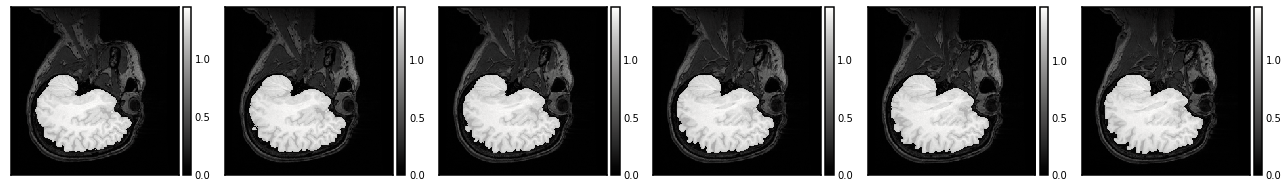

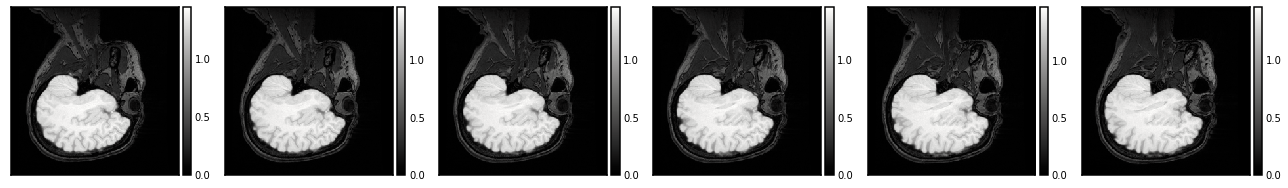

In [10]:
COLS = 6
N = 64
M = N + COLS

g = isns.ImageGrid(list((data + label)[N:M].squeeze()), col_wrap=COLS, cmap='gray')
g = isns.ImageGrid(list((data + pred)[N:M].squeeze()), col_wrap=COLS, cmap='gray')

In [11]:
from apeer_ometiff_library import io
import numpy as np

In [12]:
# shape convention (T, Z, C, X, Y)
label = label[:200].unsqueeze(0).numpy().astype(np.uint8)
pred = pred[:200].unsqueeze(0).numpy().astype(np.uint8)

label.shape

(1, 200, 1, 256, 256)

In [13]:
io.write_ometiff("label.tif", label)
io.write_ometiff("pred.tif", pred)